In [1]:
from aemulusnu_massfunction.emulator_training import *
from aemulusnu_massfunction.fisher_utils import *

In [2]:
plt.show()
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

plt.rcParams['font.size'] = 11
# import seaborn as sns

In [3]:
import matplotlib as mpl
import matplotlib.colors as mcolors


In [4]:
import os.path
import datetime
import pickle
import numpy as np
a_list_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/alist.pkl'
a_list_f = open(a_list_fname, 'rb')
a_list = pickle.load(a_list_f) 
a_list_f.close()
print('alist', a_list)

weird_boxes = []
errors = {a:{} for a in a_list}
shots = {a:{} for a in a_list}
for box in ['Box_n50_0_1400']:
    if(box in weird_boxes):
        continue
    if('n50' not in box):
        continue
    jackknife_covs_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_jackknife_covs.pkl'
    jackknife_covs_f = open(jackknife_covs_fname, 'rb')
    jackknife = pickle.load(jackknife_covs_f)
    jackknife_covs_f.close()

    for a in a_list:
        plot_data = None
        file_path = "/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_NvMfit_output.pkl" % (box, a)

        with open(file_path, "rb") as f:
            plot_data = pickle.load(f)

        model = plot_data['tinker_eval']
        true  = plot_data['N']
        edges = plot_data['edges']
        edgeslog10 = np.log10(edges)
        
        jack_error = jackknife[a][1]
        assert(jack_error.shape[0] == model.shape[0])
        assert(len(true) == len(model))
        assert(len(true) == len(edges)-1)
        for ledge, redge, model_in_bin, true_in_bin, jk_err in zip(edgeslog10, edgeslog10[1:], model, true, np.diag(jack_error)):
            ledge = np.round(ledge, decimals=1)
            redge = np.round(redge, decimals=1)
            if((ledge, redge) not in errors[a]):
                errors[a][(ledge, redge)] = []
                shots[a][(ledge, redge)] = [] 
            errors[a][(ledge, redge)] += [np.abs(model_in_bin-true_in_bin)/true_in_bin]
#             shots[a][(ledge, redge)] += [np.sqrt(true_in_bin)/true_in_bin]
            shots[a][(ledge, redge)] += [np.sqrt(jk_err) / true_in_bin]


alist [1.0, 0.953321, 0.866399, 0.787402, 0.715608, 0.65036, 0.620002, 0.591061, 0.563471, 0.537169, 0.512095, 0.488191, 0.403224, 0.366459, 0.302679]


In [5]:
labels = {
    '10^9 As': r'10^9A_s',
    'ns': r'n_s',
    'H0': r'H_0',
    'w0': r'w_0',
    'ombh2': r'\Omega_b h^2',
    'omch2': r'\Omega_c h^2',
    'nu_mass_ev': r'\sum m_\nu',
}

In [6]:
from labellines import labelLine, labelLines

In [7]:
zs = np.linspace(0,2,5)
print(zs)

[0.  0.5 1.  1.5 2. ]


In [8]:
from aemulusnu_hmf import massfunction as hmf

In [9]:
fiducial_h = 0.6736
nu_mass_ev = 0.06
fiducial_cosmology = {'10^9 As':2.1,
                      'ns': 0.9649,
                      'H0': 67.36,
                      'w0': -1,
                      'ombh2': 0.02237,
                      'omch2': 0.12,
                      'nu_mass_ev': 0.06,}

#(Same as above but put in DES Y3 OmegaM and Sigma8)
# print('DES Y3')
# Ωmh2 =  0.339*fiducial_h**2 # Y3 3x2pt
# Ωνh2 = nu_mass_ev/(93.14) #see astro-ph/0603494
# #From the BBN seciton of DES Y3 paper
# Ωbh2 = 2.195/100
# Ωch2 = Ωmh2-Ωbh2-Ωνh2
# fiducial_cosmology = {'10^9 As': 1.520813,  #from σ8 for DES Y3 3x2 and convert_sigma8_to_As.ipynb
#                       'ns': 0.9649,
#                       'H0': 67.36,
#                       'w0': -1,
#                       'ombh2': Ωbh2,
#                       'omch2': Ωch2,
#                       'nu_mass_ev': nu_mass_ev,}




fiducial_cosmo_vals = get_cosmo_vals(fiducial_cosmology)
# fiducial_ccl_cosmo = get_ccl_cosmology(tuple(fiducial_cosmo_vals))

cosmology = hmf.cosmology(fiducial_cosmology)



In [10]:
cosmos_f = open('../data/cosmo_params.pkl', 'rb')
cosmo_params = pickle.load(cosmos_f) #cosmo_params is a dict
cosmos_f.close()


print(cosmo_params['Box_n50_0_1400'])
print(fiducial_cosmology)

{'ns': 0.97000003, 'H0': 67.0, 'w0': -1.0, 'ombh2': 0.0223, 'omch2': 0.12, 'nu_mass_ev': 0.07071068, '10^9 As': 2.10100315}
{'10^9 As': 2.1, 'ns': 0.9649, 'H0': 67.36, 'w0': -1, 'ombh2': 0.02237, 'omch2': 0.12, 'nu_mass_ev': 0.06}


In [11]:
import math

def normalize_cosmology(cosmology, normalization_factors):
    return {k: v / normalization_factors[k] for k, v in cosmology.items()}

def cosmo_distance(cosmo1, cosmo2, normalization_factors):
    squared_diff_sum = 0
    for key in cosmo1:
        if key in cosmo2:
            norm_value1 = cosmo1[key] / normalization_factors[key]
            norm_value2 = cosmo2[key] / normalization_factors[key]
            squared_diff_sum += (norm_value1 - norm_value2)**2
    return math.sqrt(squared_diff_sum)

def find_closest_cosmology(fiducial_cosmology, cosmo_params):
    # Calculate normalization factors (using the fiducial cosmology as reference)
    normalization_factors = {k: abs(v) for k, v in fiducial_cosmology.items()}
    
    closest_key = None
    min_distance = float('inf')
    
    for key, cosmology in cosmo_params.items():
        distance = cosmo_distance(fiducial_cosmology, cosmology, normalization_factors)
        if distance < min_distance:
            min_distance = distance
            closest_key = key
    
    return closest_key

# Assuming cosmo_params is defined
closest_key = find_closest_cosmology(fiducial_cosmology, cosmo_params)
print(f"The closest cosmology to the fiducial model is: {closest_key}")


The closest cosmology to the fiducial model is: Box_n50_0_1400


In [12]:
jackknife_covs_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+closest_key+'_jackknife_covs.pkl'
jackknife_covs_f = open(jackknife_covs_fname, 'rb')
jackknife = pickle.load(jackknife_covs_f)
jackknife_covs_f.close()


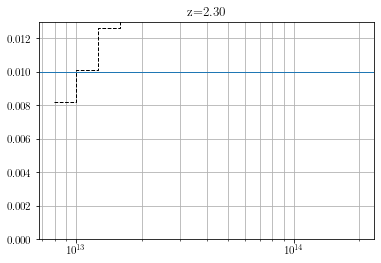

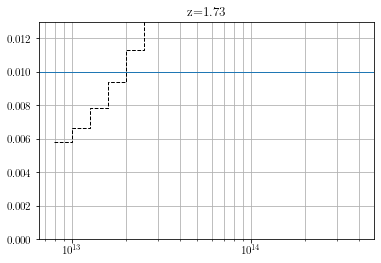

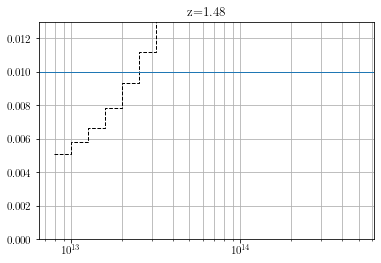

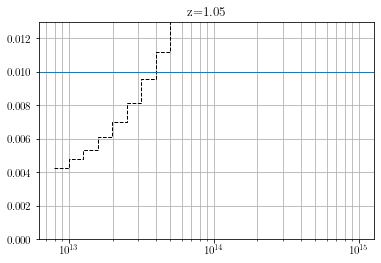

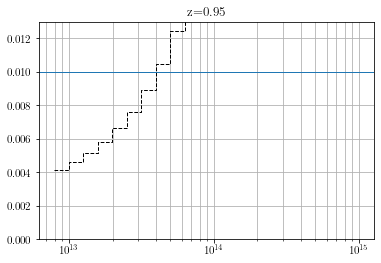

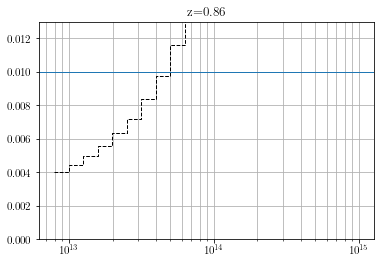

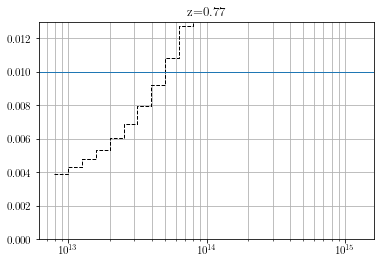

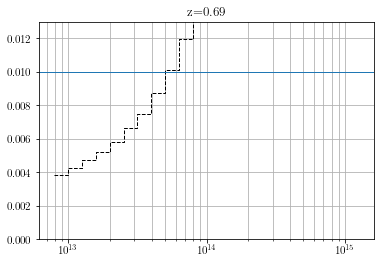

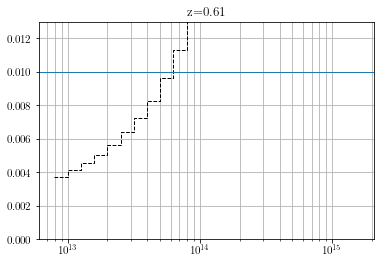

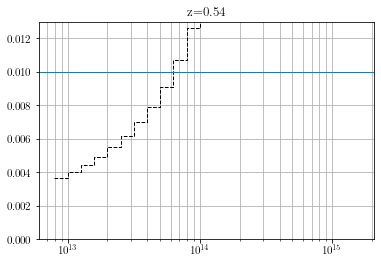

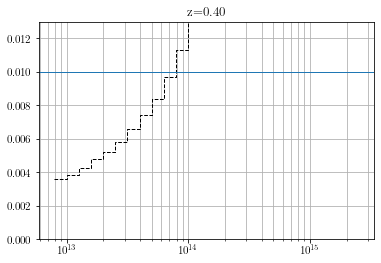

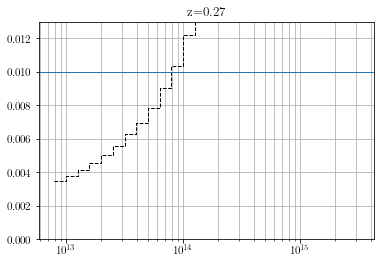

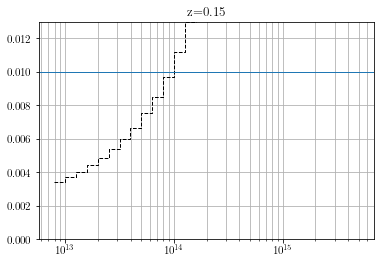

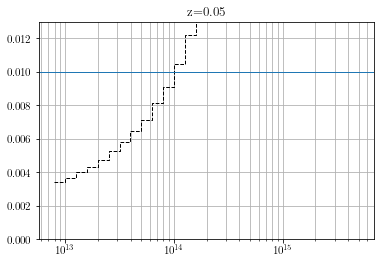

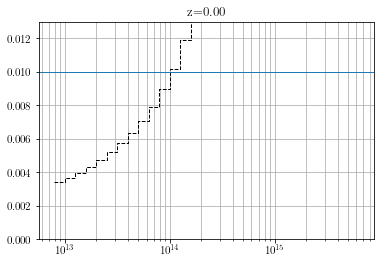

In [13]:
for key in jackknife:
    plot_data = None
    file_path = "/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_NvMfit_output.pkl" % (closest_key, key)

    with open(file_path, "rb") as f:
        plot_data = pickle.load(f)

    model = plot_data['tinker_eval']
    true  = plot_data['N']
    edges = plot_data['edges']
    edgeslog10 = np.log10(edges)
    jackknifed_noise = np.sqrt(np.diag(jackknife[key][1]))/true
    jackknifed_noise = jackknifed_noise.tolist()
#     print(np.shape(np.diag(jackknife[key][1])))
#     print(np.shape(edgeslog10))
#     print(np.shape(true))

#     print()
    plt.step(edges, jackknifed_noise+[jackknifed_noise[-1]], 'k--', where='post', linewidth=1)
    plt.title('z=%.2f'%scaleToRedshift(key))
    plt.xscale('log')
    plt.axhline(0.01, lw=1)
    plt.ylim(0, 0.013)
    plt.grid(axis='both', which='both')
    plt.show()
    

In [14]:
zs

array([0. , 0.5, 1. , 1.5, 2. ])

In [22]:
MMAX = dict(zip(zs, [14.05, 13.75, 13.65, 13.45, 13.35,])) #MSol / h
MMAX_in_Msol = {curr_z: np.log10(10**(MMAX[curr_z]) / fiducial_h) for curr_z in MMAX}

In [23]:
MMAX

{0.0: 14.05, 0.5: 13.75, 1.0: 13.65, 1.5: 13.45, 2.0: 13.35}

In [44]:
cosmo_pluses = {}
cosmo_minuses = {}
for varied_param in ['nu_mass_ev', 'ombh2'  , '10^9 As', 'omch2', 'ns', 'H0', ]:
    step = np.abs(fiducial_cosmology[varied_param]) * 10**(fiducial_log10_rel_step_size[varied_param])


    cosmology_plus = fiducial_cosmology.copy()
    cosmology_plus[varied_param] +=  step
    cosmo_plus = hmf.cosmology(cosmology_plus)
    cosmo_pluses[varied_param] = cosmo_plus
    
    cosmology_minus = fiducial_cosmology.copy()
    cosmology_minus[varied_param] -=  step
    cosmo_minus = hmf.cosmology(cosmology_minus)
    cosmo_minuses[varied_param] = cosmo_minus

[0.  0.4 0.8 1.2 1.6 2. ]


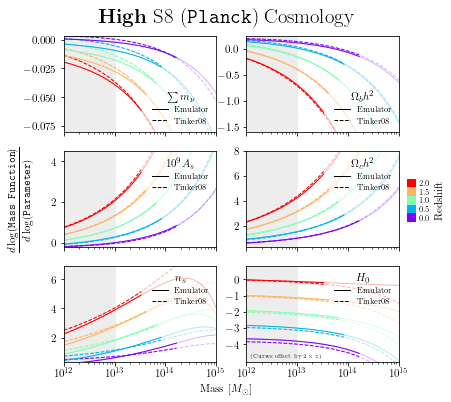

In [49]:
rainbow = mpl.colormaps['rainbow'].resampled(len(zs))
rainbow_list = [mcolors.rgb2hex(rainbow(i)) for i in range(rainbow.N)]

varied_param = 'nu_mass_ev'


fig, meta_axs = plt.subplots(3,2, figsize=(6,6), sharex=True)
meta_axs[0][0].set_ylim(-0.08, 0.003)
meta_axs[0][1].set_ylim(-1.60, 0.24)
meta_axs[1][0].set_ylim(-0.2, 4.5)
meta_axs[1][1].set_ylim(0.3, 8.00)
meta_axs[2][0].set_ylim(0.3,  6.9)
meta_axs[2][1].set_ylim(-1.1,  5.20)



for ax in meta_axs.flatten():
    ax.fill_between([1e12, 1e13], [-1000, -1000],[1000,1000], color='0.93')

for varied_param,axs,CLOC in zip(['nu_mass_ev', 'ombh2'  , '10^9 As', 'omch2', 'ns', 'H0', ], 
                                 meta_axs.flatten(),
                                ['lower right', 'lower right', 'upper right', 'upper right', 'upper right', 'upper right']):
    step = np.abs(fiducial_cosmology[varied_param]) * 10**(fiducial_log10_rel_step_size[varied_param])


    cosmology_plus = fiducial_cosmology.copy()
    cosmology_plus[varied_param] +=  step
    cosmo_plus = cosmo_pluses[varied_param]

    cosmology_minus = fiducial_cosmology.copy()
    cosmology_minus[varied_param] -=  step
    cosmo_minus = cosmo_minuses[varied_param]

    h = fiducial_cosmology['H0']/100
    bounds_that_matter_y = [np.inf,-np.inf]
    for i, (mf,lbl) in enumerate(zip([Tinker08Costanzi13(), MassFuncAemulusNu_GP_emulator_training() ], 
                           [ 'tinker', 'aemulus',])):

        for j,z_curr in enumerate(zs):
            # NOTE: `M` here is in units of Msol (NO little h units like usual) 
            # so that it is independent of cosmology
            M = 10**np.linspace(12, MMAX_in_Msol[z_curr], 150) 
            h_cosmo_minus = cosmology_minus['H0']/100
            h_cosmo_plus  = cosmology_plus['H0']/100

            dndm_plus = mf(cosmo_plus,   M*h_cosmo_plus,  redshiftToScale(z_curr))
            dndm_minus = mf(cosmo_minus, M*h_cosmo_minus, redshiftToScale(z_curr))
            dndm_dAs = (dndm_plus- dndm_minus)/(2*step)
            dndm_fid = mf(cosmology,  M*fiducial_h, redshiftToScale(z_curr))
            
            sty = '-'
            if(i==0):
#                 print(mf.name)
                sty = '--'
            tmp = 0
            if(varied_param == 'H0'):
                tmp = 2*z_curr 
            
            plotted_data = fiducial_cosmology[varied_param]*dndm_dAs/dndm_fid+ tmp
            axs.plot(M , plotted_data, 
                     sty, color=rainbow_list[j], lw=1)
            meta_axs[0][0].set_ylim(-0.08, 0.003)
            meta_axs[0][1].set_ylim(-1.60, 0.24)
            meta_axs[1][0].set_ylim(-0.2, 4.5)
            meta_axs[1][1].set_ylim(0.3, 8.00)
            meta_axs[2][0].set_ylim(0.3,  6.9)
            meta_axs[2][1].set_ylim(-1.1,  5.20)

            
            YLO, YHI = plotted_data.min() , plotted_data.max()
            if(YLO < bounds_that_matter_y[0]):
                bounds_that_matter_y[0] = YLO
            if(YHI > bounds_that_matter_y[1]):
                bounds_that_matter_y[1] = YHI
                
            M = 10**np.linspace(12, 16, 150)

            dndm_plus = mf(cosmo_plus,   M*h_cosmo_plus,  redshiftToScale(z_curr))
            dndm_minus = mf(cosmo_minus, M*h_cosmo_minus, redshiftToScale(z_curr))
            dndm_dAs = (dndm_plus- dndm_minus)/(2*step)
            dndm_fid = mf(cosmology,  M*fiducial_h, redshiftToScale(z_curr))
            
            sty = '-'
            if(i==0):
#                 print(mf.name)
                sty = '--'
            tmp = 0
            if(varied_param == 'H0'):
                tmp = 2*z_curr 
                
            axs.plot(M , fiducial_cosmology[varied_param]*dndm_dAs/dndm_fid+ tmp, 
                     sty, color=rainbow_list[j], lw=1, alpha=0.3)
            meta_axs[0][0].set_ylim(-0.08, 0.003)
            meta_axs[0][1].set_ylim(-1.60, 0.24)
            meta_axs[1][0].set_ylim(-0.2, 4.5)
            meta_axs[1][1].set_ylim(0.3, 8.00)
            meta_axs[2][0].set_ylim(0.3,  6.9)
            meta_axs[2][1].set_ylim(-1.1,  5.20)

    if(bounds_that_matter_y[0]<0):
        bounds_that_matter_y[0]*=1/0.8
    else:
        bounds_that_matter_y[0]*=0.8
    
    if(bounds_that_matter_y[1]<0):
        bounds_that_matter_y[1]*=0.8
    else:
        bounds_that_matter_y[1]*=1/0.8
    axs.set_ylim(bounds_that_matter_y[0], bounds_that_matter_y[1])
#     labelLines(axs.get_lines(), zorder=2, fontsize=8)

#     print(labels[varied_param])
    tmp0, tmp1 = (axs.get_ylim())

    axs.plot([-1,0], [-1,0], 'k-', lw=1, label='Emulator')
    axs.plot([-1,0], [-1,0], 'k--', lw=1, label='Tinker08')

    axs.legend(title = r'$%s$'%labels[varied_param], 
               frameon=False, fontsize=8,
              loc=CLOC);
#     axs.set_ylim(tmp0, tmp1)

    if(varied_param == 'H0'):
        axs.text(.025, .025, s=r'(Curves offset by $2\times z$)',
            transform=axs.transAxes,
            horizontalalignment='left',
            verticalalignment='bottom',
            c='black',
            fontsize=5)
        axs.set_yticks([-4, -3, -2, -1, 0])
        axs.set_ylim(tmp0, tmp1+.05*tmp1)

    axs.set_xscale('log')
    axs.set_xlim(1e12, 1e15)
    
    
#         axs.set_ylim(-.15, .15)
    
    
fig.text(0.05, 0.5, r'$$\frac{d\log(\texttt{Mass Function})}{d\log(\texttt{Parameter})}$$'+'\n\n', 
         ha='center', 
         va='center', 
         rotation='vertical',
        fontsize=11)

fig.text(0.5, 0.9, r'\huge \textbf{High} S8 (\texttt{Planck}) Cosmology',
         ha='center', 
         va='bottom', 
        fontsize=11)


    
fig.text(0.5, 0.075, r'Mass $[ M_\odot]$',
         ha='center', 
         va='top', 
        fontsize=11)


fig.colorbar_ax = fig.add_axes([0.92, 0.45, 0.02, 0.1])  # Adjust the position and size as needed

# Create a colormap from the list of colors
cmap = mpl.colors.ListedColormap(rainbow_list)

# Create a boundary norm with boundaries in the middle of the z values
boundaries = np.linspace(zs.min(), zs.max(), len(zs)+1)
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N, clip=True)
print(boundaries)
# Create a colorbar with the custom cmap and norm
cb = mpl.colorbar.ColorbarBase(fig.colorbar_ax, 
                               cmap=cmap, 
                               norm=norm, 
#                                boundaries=boundaries[:-1], 
                               ticks=[0.2, 0.6,1,1.4,1.8])

# Set the tick labels to the corresponding z values

cb.set_ticklabels([f'{z:.1f}' for z in zs])

cb.outline.set_visible(False)

cb.set_label('Redshift')

cb.ax.tick_params(labelsize=8)
cb.ax.tick_params(size=0)
cb.ax.yaxis.set_tick_params(size=0)  # Hide the ticks
fig.colorbar_ax.tick_params(size=0)
fig.colorbar_ax.tick_params(which='both', size=0)

# Make sure the colorbar is only as tall as the subplots
fig.subplots_adjust(right=0.9)  # Adjust the right parameter to make room for the colorbar

# for ax in meta_axs.flatten():
#     print(ax.get_ylim())
meta_axs[0][0].set_ylim(-0.08, 0.003)
meta_axs[0][1].set_ylim(-1.60, 0.24)
meta_axs[1][0].set_ylim(-0.2, 4.5)
meta_axs[1][1].set_ylim(0.3, 8.00)
meta_axs[2][0].set_ylim(0.3,  6.9)
meta_axs[2][1].set_ylim(-5.1,  0.8)

plt.savefig('log_deriv.pdf',bbox_inches='tight')